In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import random
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from keras.preprocessing.image import load_img

In [2]:
#!pip install segmentation-models #https://segmentation-models.readthedocs.io/en/latest/tutorial.html
# https://github.com/qubvel/segmentation_models/blob/master/docs/tutorial.rst

     |████████████████████████████████| 50 kB 8.3 MB/s 


In [2]:
# fix the error:
# import tensorflow as tf
# tf.keras.utils.get_file @ line 201, and @ line 207
# restart the runtime
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [3]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/AI_Projects/Segmentor')
# MAKE SURE YOU ARE IN HIGH RAM AND GPU

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# ------------------------------------------------------
# Constants
# ------------------------------------------------------
N_CLASSES = 21 # background + 20 types of objects
PATH_MODELS = "models/"
PATH_SAVED_DATASET = "datasets/pascal/"
PATH_INPUT_TRAIN_IMAGE = "/datasets/pascal/Segmentation_input/train/"
PATH_INPUT_TRAIN_MASK = "/datasets/pascal/Segmentation_output/train/"
PATH_INPUT_VALID_IMAGE = "/datasets/pascal/Segmentation_input/validation/"
PATH_INPUT_VALID_MASK = "/datasets/pascal/Segmentation_output/validation/"
PATH_CLASSES_PER_IMAGE = "/datasets/pascal/pascal_segmented_classes_per_image_selections.csv"
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
TRAIN_PERCENT_LOAD = 100
TEST_PERCENT_LOAD = 100

VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]

VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

# Loading the original dataset

In [ ]:
# Source: https://d2l.ai/chapter_computer-vision/semantic-segmentation-and-dataset.html

def voc_colormap2label():
    """
    Build the mapping from RGB to class indices for VOC labels

    Arguments:
    - None

    Returns:
    - colormap2label: 
    """
    colormap2label = np.zeros(256**3)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i

    return colormap2label

def voc_label_indices(colormap, colormap2label):
    """
    Map any RGB values in VOC labels to their class indices

    Arguments:
    - colormap:
    - colormap2label:

    Returns:
    - class_index:
    """
    colormap = colormap.astype(np.int32)
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 + colormap[:, :, 2])
    class_index = colormap2label[idx]

    return class_index



In [ ]:
def load_train_dataset(selection_column = None):
    """
    TODO

    Arguments:
    - selection_column: column that reflects the selection on the classes

    Returns:
    - X_train, X_test, Y_train, Y_test
    """
    
    # Selecting which files to load
    random.seed(0)
    files_list_total = os.listdir(os.getcwd() + PATH_INPUT_TRAIN_IMAGE)
    df_files = pd.DataFrame(files_list_total, columns = ["image_filename"])
    print(f"df_files shape is {df_files.shape}")
    print(df_files.head())

    # Now perform the subselection
    if selection_column is not None:
        pascal_classes_per_image = pd.read_csv(os.getcwd() + PATH_CLASSES_PER_IMAGE)
        df_selection = pascal_classes_per_image[pascal_classes_per_image[selection_column] == 1]
        df_selection = df_selection[["image_filename"]]
        print(f"df_selection is {df_selection.head()}")
        print(f"df_selection columns are {df_selection.columns} and shape is {df_selection.shape}")      
        df_merged_train_files = df_selection.join(df_files.set_index("image_filename"), how = "inner", on = ["image_filename"])                
        print(f"After doing inner join in the selection there are {len(df_merged_train_files)} files")
        df_files = df_merged_train_files
        print(df_files.columns)
    
    files_list_total = df_files["image_filename"].tolist()
    number_selected = int((TRAIN_PERCENT_LOAD/100)*len(files_list_total))
    files_list_selected = files_list_total[0:number_selected]
    print(f"There are {len(files_list_total)} pictures on the whole training set")
    print(f"There are {len(files_list_selected)} pictures on the selected training set")
    
    # Now load the images and the masks into an array
    X = np.zeros((number_selected, HEIGHT, WIDTH, 3))
    #Mask = np.zeros((number_selected, HEIGHT, WIDTH, 3))
    Y = np.zeros((number_selected, HEIGHT, WIDTH))
    
    for i, pic_file in enumerate(files_list_selected):
        filename_extension = pic_file.split(".")
        file_name = filename_extension[0]
        extension = filename_extension[1]
        pic_path = os.getcwd() + PATH_INPUT_TRAIN_IMAGE + file_name + "." + extension
        mask_path = os.getcwd() + PATH_INPUT_TRAIN_MASK + file_name + "." + "png"
    
        if (i % 25 == 0) or (i == len(files_list_selected)-1):
            print(f"Reading i = {i+1} / {number_selected} file is: {pic_file}")
    
        pic_resized = np.array(load_img(pic_path, color_mode = "rgb", target_size = (HEIGHT, WIDTH)))
        X[i] = pic_resized
        mask_resized = np.array(load_img(mask_path, color_mode = "rgb", target_size = (HEIGHT, WIDTH)))
        #Mask[i] = mask_resized
        y = voc_label_indices(mask_resized, voc_colormap2label())
        Y[i] = y

    print()
    print(f"X has shape {X.shape}")
    print(f"Y has shape {Y.shape}")

    # Normalize
    X = X/255.0

    return X, Y

In [ ]:
# Load and save the dataset with these lines
#X_train, Y_train = load_train_dataset()
#np.save("X_train_256_256_3_p1.npy", X_train[0:366])
#np.save("X_train_256_256_3_p2.npy", X_train[366:732])
#np.save("X_train_256_256_3_p3.npy", X_train[732:1098])
#np.save("X_train_256_256_3_p4.npy", X_train[1098:])
#np.save("Y_train_256_256_1_p1.npy", Y_train[0:366])
#np.save("Y_train_256_256_1_p2.npy", Y_train[366:732])
#np.save("Y_train_256_256_1_p3.npy", Y_train[732:1098])
#np.save("Y_train_256_256_1_p4.npy", Y_train[1098:])

#X_test, Y_test = load_validation_set()

# Loading the saved dataset

In [5]:
def load_dataset_single_part(height:int, width:int, channels:int, part:int, type_:str, path_dataset:str = PATH_SAVED_DATASET):
    """
    Loads a part of a presaved dataset

    Arguments:
    - height (int): image height dimension
    - width (int): image width dimension 
    - channels (int): channels dimension
    - part (int): subdivision of the dataset
    - type_ (str): "train" or "test"
    - path_dataset (str): path of the dataset
    
    Returns:
    - X (ndarray): of shape (m, height, width, channels)
    - Y (ndarray): of shape (m, height, width)
    """

    X = None
    Y = None
    
    try:
        X_path = path_dataset + "X_" + type_ + "_" + str(height) + "_" + str(width) + "_" + str(channels) + "_p" + str(part) + ".npy"
        X = np.load(X_path)
        print(f"Loaded {X_path} and has shape {X.shape}")
    except:
        raise Exception("Did not found file " + str(X_path))

    try:
        Y_path = path_dataset + "Y_" + type_ + "_" + str(height) + "_" + str(width) + "_" + str(1) + "_p" + str(part) + ".npy"
        Y = np.load(Y_path)
        print(f"Loaded {Y_path} and has shape {Y.shape}")
    except:
        raise Exception("Did not found file " + str(Y_path))

    return X, Y

In [6]:
def load_dataset_several_parts(height:int, width:int, channels:int, p1:int, p2:int, type_:str, path_dataset:str = PATH_SAVED_DATASET):
    """
    Loads a set of parts of the dataset between {p1, p1+1, ..., p2-1, p2}
    p1 needs to be <= p2, both >= 1

    Arguments:
    - height (int): image height dimension
    - width (int): image width dimension 
    - channels (int): channels dimension
    - p1 (int): initial part to load
    - p2 (int): final part to load
    - type_ (str): "train" or "test"
    - path_dataset (str): path of the dataset
    
    Returns:
    - X (ndarray): of shape (m, height, width, channels)
    - Y (ndarray): of shape (m, height, width)
    """
    assert p1 <= p2, "Error, p1 is > p2"
    assert p1 > 0, "Error, p1 <= 0"
    assert p2 > 0, "Error, p2 <= 0"

    X = None
    Y = None

    for i in range(p1, p2+1):
        Xi, Yi = load_dataset_single_part(height, width, channels, i, type_, path_dataset)

        # If this is the first pass initialize the arrays
        if X is None or Y is None:
            X = Xi
            Y = Yi
        # Otherwise concatenate them vertically
        else:
            X = np.vstack((X, Xi))
            Y = np.vstack((Y, Yi))
    
    print("Vertical stacking over, final shape is:")
    print(f"X shape: {X.shape}")
    print(f"Y shape: {Y.shape}")
    print()

    return X, Y

In [7]:
def one_hot_encode(M: np.array, k = N_CLASSES):
    """
    Creates the one hot encoding version of the matrix M

    Arguments:
    - M: np array
    Returns
    - ohe: one hot encoded version of the matrix M
    """
    OHE = tf.one_hot(M, depth = k)
    print(f"The OHE version has shape {OHE.shape}")
    return OHE

In [8]:
# Now we load the dataset
X_train, Y_train = load_dataset_several_parts(height = 256, width = 256, channels = 3, p1 = 1, p2 = 1, type_ = "train")
X_test, Y_test = load_dataset_several_parts(height = 256, width = 256, channels = 3, p1 = 1, p2 = 1, type_ = "test")

# Now we one hot encode the labels
Y_train_ohe = one_hot_encode(Y_train)
Y_test_ohe = one_hot_encode(Y_test)

Loaded datasets/pascal/X_train_256_256_3_p1.npy and has shape (61, 256, 256, 3)
Loaded datasets/pascal/Y_train_256_256_1_p1.npy and has shape (61, 256, 256)
Vertical stacking over, final shape is:
X shape: (61, 256, 256, 3)
Y shape: (61, 256, 256)

Loaded datasets/pascal/X_test_256_256_3_p1.npy and has shape (61, 256, 256, 3)
Loaded datasets/pascal/Y_test_256_256_1_p1.npy and has shape (61, 256, 256)
Vertical stacking over, final shape is:
X shape: (61, 256, 256, 3)
Y shape: (61, 256, 256)

The OHE version has shape (61, 256, 256, 21)
The OHE version has shape (61, 256, 256, 21)


Viewing index i = 4


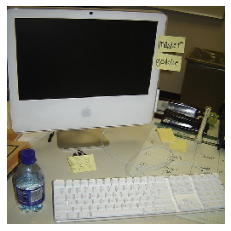

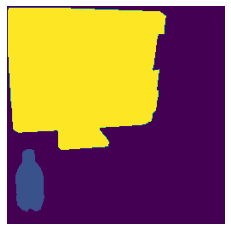

In [9]:
# Take a look at some random images
rand_index = random.choice(range(len(X_train)))
print(f"Viewing index i = {rand_index}")
plt.imshow(X_train[rand_index])
plt.axis('off')
plt.show()
plt.imshow(Y_train[rand_index])
plt.axis('off')
plt.show()

# Modelling

### Auxiliar

In [10]:
class Model:
    """
    Creates an instance of Model Class

    Arguments:
    - id (str): the id of this model
    - keras_model: a model to be instantiated or to be loaded later if this argument is none
    - model_folder: path to where the models are
    """

    # Class static parameters
    metrics_column_names = ["epoch", 'loss', 'mIoU', 'val_loss', 'val_mIoU']

    def __init__(self, id:str, keras_model = None, model_folder = PATH_MODELS):
        
        self.id = id
        self.keras_model = keras_model
        self.history_path = model_folder + "m" + self.id + ".csv"
        self.model_path = model_folder + "m" + self.id + ".h5"
        callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(self.model_path, monitor = "val_mIoU", verbose = 1, save_best_only = True, mode = "max")        
        self.callbacks = [callback_checkpoint]

    def load_model(self):
        """
        Loads the .h5 model file into this instance

        Arguments:
            None
        
        Returns:
            None
        """
        if os.path.isfile(self.model_path):
            self.keras_model = tf.keras.models.load_model(self.model_path, compile = True)
            self.keras_model.compile (loss = self.keras_model.loss, 
                                      optimizer = self.keras_model.optimizer, 
                                      metrics = [MeanIoU(num_classes = N_CLASSES, name = "mIoU")])
            print(f"Successfully loaded model {self.model_path}")
        else:
            print("Previous saved model not found")
    
    def load_history(self):
        """
        Loads the .csv training history file as a dataframe and retrieves the last epoch of training

        Arguments:
            None
        
        Returns:
            history (pd.DataFrame)
            last_epoch (int)
        """
        df = None
        last_epoch = -1
        if os.path.isfile(self.history_path):
            df = pd.read_csv(self.history_path)[Model.metrics_column_names]
            last_epoch = df["epoch"].max()
            print(f"Last training history read, last epoch was #{last_epoch}")
        else:
            print("Last training history not found")
        
        return df, last_epoch
    
    def plot_learning_curves(self):
        """
        Plots the training and validation loss curves and metrics over epochs from the saved history .csv file

        Arguments:
            None
        
        Returns:
            None
        """
        df, last_epoch = self.load_history()        
        if df is not None:
            
            fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 6))
            
            # Figure 1: Loss
            ax1.plot(df['loss'])
            ax1.plot(df['val_loss'])
            ax1.set_title("Loss over epochs")
            ax1.set(xlabel = "Epochs", ylabel="Loss")
            ax1.legend(['Train', 'Test'], loc='upper right')
            
            # Figure 2: Metric
            ax2.plot(df['mIoU'])
            ax2.plot(df['val_mIoU'])
            ax2.set_title("mIoU over epochs")
            ax2.set(xlabel = "Epochs", ylabel="mIoU")
            ax2.legend(['Train', 'Test'], loc='upper left')            
            
            plt.tight_layout()
            plt.show()
        else:
            print("no history file found")
    
    def retrieve_metrics(self, history):
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        mIOU = history.history['mIoU']
        val_mIOU = history.history['val_mIoU']
        return loss, val_loss, mIOU, val_mIOU

    def fit(self, X_train: np.array, Y_train: np.array, X_test: np.array, Y_test: np.array, batch_size: int, epochs: int):
        """
        Fits the model with the traditional fit function from Keras and saves the history to a .csv file

        Arguments:
            X_train:
            Y_train:
            X_test:
            Y_test:
            batch_size:
            epochs:
        
        Returns:
            None
        """
        # If the model does not exists load it
        if self.keras_model is None:
            self.load_model()
        
        # Load previous history
        old_df, last_epoch = self.load_history()
        
        # Now train
        if self.keras_model is not None:
            history_new = self.keras_model.fit(x = X_train, 
                                               y = Y_train, 
                                               batch_size = batch_size, 
                                               epochs = epochs, 
                                               verbose = 1, 
                                               validation_data = (X_test, Y_test),
                                               callbacks = self.callbacks                                               
                                               )
            
            # Retrieve metrics
            print("\n\tTraining finished!")
            loss, val_loss, mIOU, val_mIOU = self.retrieve_metrics(history_new)
            epochs = [last_epoch + 1 + i for i in range(len(loss))]
            new_df = pd.DataFrame(list(zip(epochs, loss, mIOU, val_loss, val_mIOU)), 
                                  columns = Model.metrics_column_names)[Model.metrics_column_names]

            # Append new df to old df
            if old_df is not None:
                new_df = old_df.append(new_df)[Model.metrics_column_names]
            
            # Now save the final history
            new_df.to_csv(self.history_path)
            print(f"\n\tNew training history updated to file {self.history_path}")

        else:
            print("\tmodel is not found, training aborted")

In [11]:
def get_indices_from_prediction(prediction: np.array) -> np.array:
    """
    Takes a prediction of shape (m,h,w,n) and outputs the predicted class for each pixel

    Arguments:
    - prediction (np.array): np array of shape (m,h,w,n)
    - n_classes (int): classes available

    Returns:
    - class_per_pixel (np.array): np array of shape (m,h,w)
    """

    assert len(prediction.shape) == 4, "prediction input has shape " + str(prediction.shape) + " and it should be length = 4"
    class_per_pixel = np.argmax(prediction, axis = 3)
    return class_per_pixel

In [25]:
def evaluate_mIOU_on_set(model: tf.keras.Model, X: np.array, Y: np.array):
    """
    Takes a model and evaluates the mIOU on a set

    Arguments:
    - model (tf.keras.Model): the keras model
    - X (np.array): the np.array of the image, has shape (m,h,w,c) and its normalized
    - Y (np.array): the np.array of the mask, has shape (m,h,w)

    Returns:
    - mIoU: the score of the mean intersection over union
    """
    min_X = np.amin(X)
    max_X = np.amax(X)
    assert min_X >= 0 and min_X <= 1, "the min of X should be between 0 and 1 and its " + str(min_X)
    assert max_X >= 0 and max_X <= 1, "the max of X should be between 0 and 1 and its " + str(max_X)

    pred = get_indices_from_prediction(model.predict(X))
    IOU_keras = MeanIoU(num_classes = N_CLASSES) 
    IOU_keras.update_state(Y, pred)
    mIoU = IOU_keras.result().numpy()
    return mIoU

In [ ]:
def compare_prediction_and_truth(model: tf.keras.Model, x: np.array, y: np.array):
    """
    Takes a model and compares the prediction with the truth, then plots it.
    Plots:
    - first line: mIOU
    - second line: Original image, truth mask, prediction, overlay and legend
    
    Arguments:
    - model (keras.Model)
    - x (np.array): normalized image of shape (h,w,c)
    - y (np.array): mask of shape (h,w)

    Returns:
    - None
    """
    return 1

## Model v01

In [31]:
def model_01():
    # Model with transfer learning
    input_shape_ = (HEIGHT, WIDTH, CHANNELS)

    backbone_model = tf.keras.applications.Xception(
        weights = 'imagenet',  # Load weights pre-trained on ImageNet.
        input_shape = input_shape_,
        include_top = False, # Do not include the ImageNet classifier at the top.
        pooling = None
    )

    # Here we freeze the base model
    backbone_model.trainable = False

    # Now we create a model on top of this
    input = tf.keras.Input(shape = input_shape_)
    x = backbone_model(input, training = False)

    # Upsampling
    x = UpSampling2D(size = 4, data_format = "channels_last", interpolation = "bilinear")(x)
    x = Conv2D(filters = 256, kernel_size = (1,1), padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    x = SpatialDropout2D(rate = 0.25, data_format = "channels_last")(x)
    x = UpSampling2D(size = 4, data_format = "channels_last", interpolation = "bilinear")(x)
    x = Conv2D(filters = 256, kernel_size = (1,1), padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    x = SpatialDropout2D(rate = 0.25, data_format = "channels_last")(x)
    x = UpSampling2D(size = 2, data_format = "channels_last", interpolation = "bilinear")(x)
    final = Conv2D(filters = N_CLASSES, kernel_size = (1,1), padding = "same", activation = "softmax", kernel_initializer = "he_normal")(x)

    # New model
    model = tf.keras.Model(inputs = input, outputs = final)

    # TODO Make sure loss it is not considering background when evaluating
    # TODO Test dice loss
    model.compile(optimizer = Adam(learning_rate = 0.001), 
                loss = "categorical_crossentropy", 
                metrics = [MeanIoU(num_classes = N_CLASSES, name = "mIoU")])
    #print(model.summary())
    return model

In [38]:
# Create a new Model
# M01 = Model("01", model_01())

# Load previous model
M01 = Model("01", None)
#M01.keras_model.summary()

In [39]:
M01.fit(X_train, Y_train_ohe, X_test, Y_test_ohe, batch_size = 16, epochs = 2)

Successfully loaded model models/m01.h5
Last training history read, last epoch was #3
Epoch 1/2
4/4 [==============================] - 20s 903ms/step - loss: 0.7034 - mIoU: 0.4739 - val_loss: 0.8333 - val_mIoU: 0.4733

Epoch 00001: val_mIoU improved from -inf to 0.47328, saving model to models/m01.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/2
4/4 [==============================] - 2s 457ms/step - loss: 0.6187 - mIoU: 0.4750 - val_loss: 0.8111 - val_mIoU: 0.4737

Epoch 00002: val_mIoU improved from 0.47328 to 0.47367, saving model to models/m01.h5

	Training finished!

	New training history updated to file models/m01.csv


Last training history read, last epoch was #5


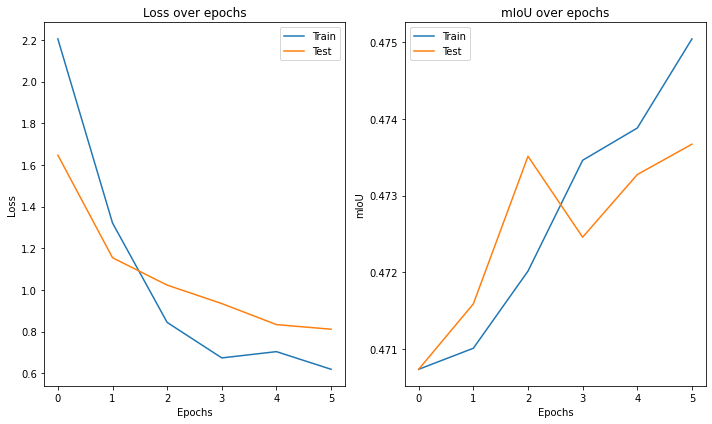

In [41]:
M01.plot_learning_curves()

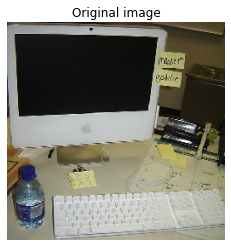

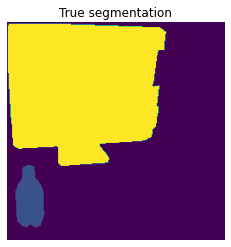

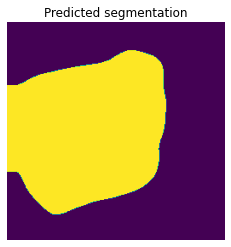

In [44]:
model = M01.keras_model
test_image_index = 4
pred_pixel_vector = model.predict(X_train[test_image_index][np.newaxis,:])
pred_pixel_index = get_indices_from_prediction(pred_pixel_vector)
plt.imshow(X_train[test_image_index])
plt.axis('off')
plt.title("Original image")
plt.show()
plt.imshow(Y_train[test_image_index])
plt.axis('off')
plt.title("True segmentation")
plt.show()
plt.imshow(pred_pixel_index[0])
plt.axis('off')
plt.title("Predicted segmentation")
plt.show()

## Model v02

In [14]:
# Define model
model02 = sm.Unet(
        backbone_name = "vgg16",
        input_shape = (HEIGHT, WIDTH, CHANNELS),
        classes = N_CLASSES,
        activation ='softmax',
        weights = None,
        encoder_weights = 'imagenet',
        encoder_freeze = True
        )

model02.compile(
    Adam(learning_rate=0.001), 
    loss = sm.losses.CategoricalFocalLoss(), 
    metrics = [sm.metrics.IOUScore([1]*N_CLASSES,name="mIoU")]
    )

# Instantiate the object
M = Model("02", model02)

In [45]:
# Run this to load the saved model id = 02
M = Model("02", None)

In [15]:
M.fit(X_train, Y_train_ohe, X_test, Y_test_ohe, 16, 2)

Last training history not found
Epoch 1/2
4/4 [==============================] - 6s 748ms/step - loss: 0.0366 - mIoU: 0.0090 - val_loss: 0.1264 - val_mIoU: 0.0052

Epoch 00001: val_mIoU improved from -inf to 0.00525, saving model to models/m02.h5
Epoch 2/2
4/4 [==============================] - 1s 269ms/step - loss: 0.0314 - mIoU: 0.0114 - val_loss: 0.1409 - val_mIoU: 0.0041

Epoch 00002: val_mIoU did not improve from 0.00525

	Training finished!

	New training history updated to file models/m02.csv


index image = 42


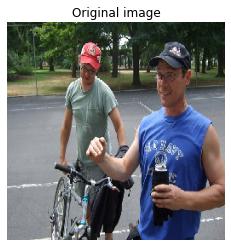

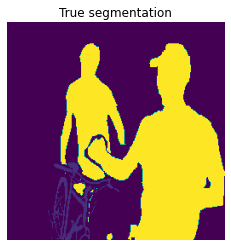

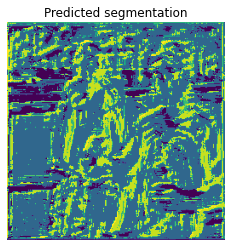

Mean IoU = 0.00105959


In [23]:
model = M.keras_model
test_image_index = 42 #random.choice(range(len(X_test)))
print(f"index image = {test_image_index}")
pred_pixel_vector = model.predict(X_test[test_image_index][np.newaxis,:])
pred_pixel_index = get_indices_from_prediction(pred_pixel_vector)
plt.imshow(X_test[test_image_index])
plt.axis('off')
plt.title("Original image")
plt.show()
plt.imshow(Y_test[test_image_index])
plt.axis('off')
plt.title("True segmentation")
plt.show()
plt.imshow(pred_pixel_index[0])
plt.axis('off')
plt.title("Predicted segmentation")
plt.show()
IOU_keras = MeanIoU(num_classes = N_CLASSES)  
IOU_keras.update_state(Y_test[test_image_index],pred_pixel_index[0]) 
print("Mean IoU =", IOU_keras.result().numpy())

In [24]:
mIOU_test = evaluate_mIOU_on_set(model, X_test, Y_test)
#mIOU_train = evaluate_on_set(model, X_train, Y_train)
#print(f"mIoU on train = {mIOU_train}")
print(f"mIoU on test = {mIOU_test}")

mIoU on test = 0.0034276172518730164
